In [1]:
import torch
print(torch.__version__)

2.5.0+cu121


In [2]:
!python --version

Python 3.10.12


In [3]:
!rm -rf /content/bert_imb

# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using DistilBert** </font>

**Objective:**

In this notebook, we aim to build the base model without accounting for the data imbalance. We will learn how the label imbalance can influence our results.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [4]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00


<font color = 'indianred'> *Load Libraries* </font>

In [5]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [6]:
set_seed(42)

In [7]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [8]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [9]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [10]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [11]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [12]:
stack_dataset = Dataset.from_pandas(df)

In [13]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tag_Number']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [14]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [15]:
df = stack_selected_columns[:]

In [16]:
df['tag_mod'] = df['tag'].apply(lambda x: ast.literal_eval(x))

In [17]:
label_encoder = MultiLabelBinarizer()

In [18]:
df['label'] = list(label_encoder.fit_transform(df['tag_mod']))

In [19]:
df_final = df[['text', 'label']]

In [20]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [21]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [22]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [23]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [24]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [25]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [26]:
train_val_subset['train']['label'][0]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [27]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [28]:
free_gpu_memory()

GPU memory has been freed.


In [29]:
checkpoint = "google/gemma-2-2b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [30]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [31]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [33]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [34]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [35]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [36]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [37]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [38]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


##  <font color = 'indianred'> **6.3 PEFT Setup**

In [39]:
model

Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforw

In [40]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [41]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['v_proj',
 'k_proj',
 'gate_proj',
 'up_proj',
 'score',
 'o_proj',
 'q_proj',
 'down_proj']

In [42]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 166,156,800 || all params: 2,780,521,728 || trainable%: 5.9757


In [43]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [44]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

##  <font color = 'indianred'> **6.4 compute_metrics function** </font>



In [45]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [46]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/gemma_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [47]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_k

##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [48]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [49]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [50]:
pos_weights

tensor([  3.3290,   4.7637,   7.4388,   0.7422,   5.5789,   0.8939,  59.6061,
        132.3333, 180.8182,   2.7594])

In [51]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [52]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-52-fcc51a4c04a4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [53]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training and Validation**

In [54]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,4.283200,1.947823,0.435591,0.320198,0.714550,0.027000
40,2.328400,1.220302,0.643119,0.490470,0.829750,0.225000
60,1.685300,1.132631,0.738270,0.569710,0.882300,0.425000
80,0.696700,1.064671,0.835060,0.683333,0.930750,0.609000
100,0.660200,0.829440,0.833959,0.693503,0.927050,0.565500
120,0.494600,0.849516,0.839561,0.710650,0.931300,0.613500


<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [55]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [56]:
eval_results

{'eval_loss': 0.8495158553123474,
 'eval_f1_micro': 0.8395609528257824,
 'eval_f1_macro': 0.7106501051101206,
 'eval_accuracy_label': 0.9313,
 'eval_accuracy_all': 0.6135,
 'eval_runtime': 45.0963,
 'eval_samples_per_second': 44.35,
 'eval_steps_per_second': 2.772,
 'epoch': 1.984}

In [57]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> *Finetune threshold* </font>

In [58]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [59]:
valid_logits.shape

(2000, 10)

In [60]:
valid_probs.shape

(2000, 10)

In [61]:
valid_labels.shape

(2000, 10)

In [62]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [63]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [64]:
optimal_thresholds

[0.5655386447906494,
 0.861527681350708,
 0.6311386823654175,
 0.23161496222019196,
 0.7764991521835327,
 0.2708659768104553,
 0.7853056192398071,
 0.4959776997566223,
 0.7745365500450134,
 0.7371581792831421]

In [65]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [66]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.8634566178180972,
 'f1_macro': 0.740456911799388,
 'accuracy_label': 0.9413,
 'accuracy_all': 0.6445}

<font color = 'indianred'> *Confusion Matrix*</font>

In [67]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[1393  163]
  [  58  386]]

 [[1639   30]
  [  33  298]]

 [[1709   70]
  [  59  162]]

 [[ 656  158]
  [ 115 1071]]

 [[1688    6]
  [  36  270]]

 [[ 765  164]
  [  53 1018]]

 [[1943   23]
  [   8   26]]

 [[1958   18]
  [   9   15]]

 [[1975   11]
  [  10    4]]

 [[1388   77]
  [  73  462]]]


In [68]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


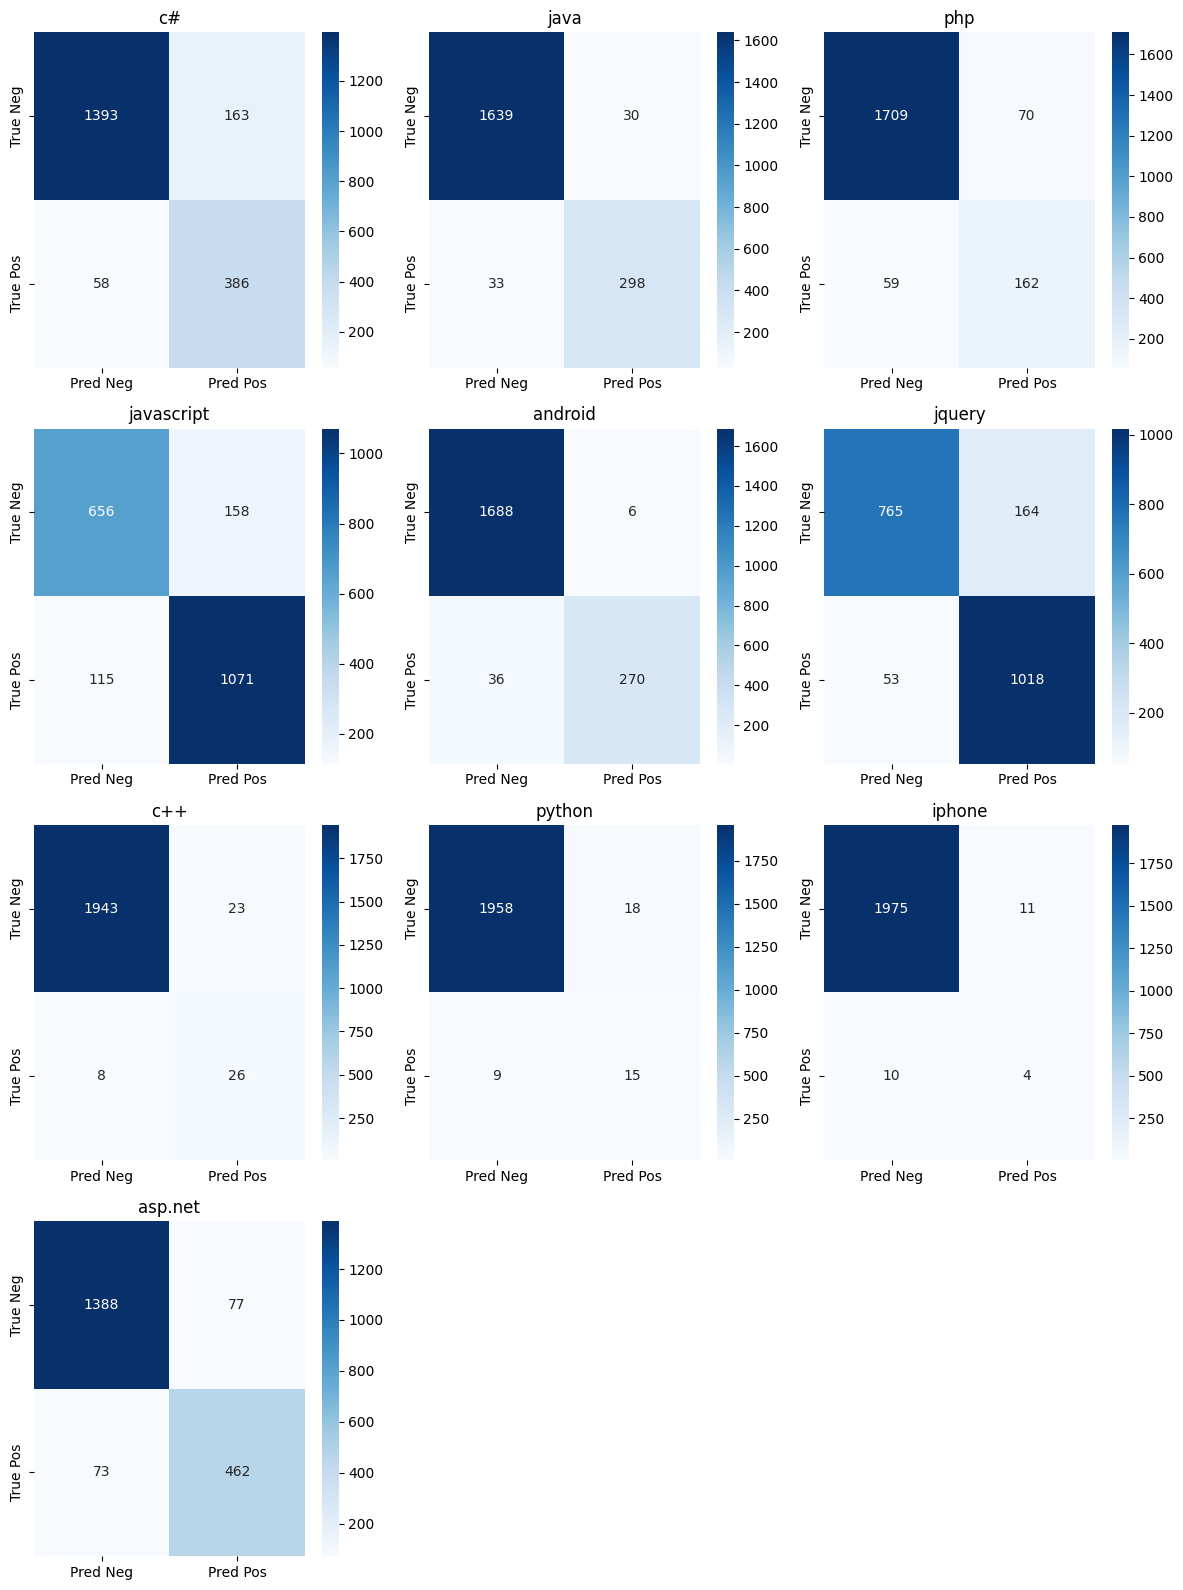

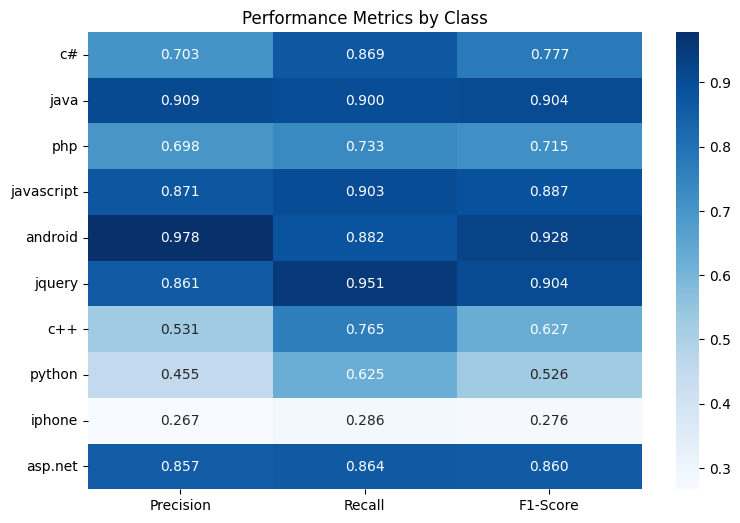

<Figure size 1200x533.333 with 0 Axes>

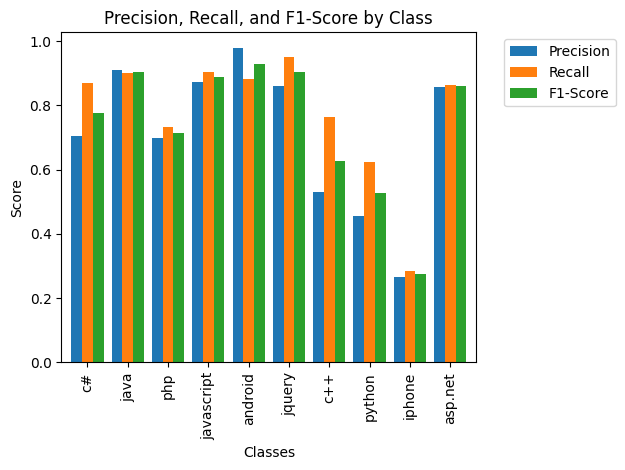

{'macro_avg': {'precision': 0.7129829389755024,
  'recall': 0.7777576621396285,
  'f1': 0.740456911799388},
 'per_class': {'Precision': {'c#': 0.7030965391621129,
   'java': 0.9085365853658537,
   'php': 0.6982758620689655,
   'javascript': 0.871440195280716,
   'android': 0.9782608695652174,
   'jquery': 0.8612521150592216,
   'c++': 0.5306122448979592,
   'python': 0.45454545454545453,
   'iphone': 0.26666666666666666,
   'asp.net': 0.8571428571428571},
  'Recall': {'c#': 0.8693693693693694,
   'java': 0.9003021148036254,
   'php': 0.7330316742081447,
   'javascript': 0.903035413153457,
   'android': 0.8823529411764706,
   'jquery': 0.9505135387488328,
   'c++': 0.7647058823529411,
   'python': 0.625,
   'iphone': 0.2857142857142857,
   'asp.net': 0.8635514018691589},
  'F1-Score': {'c#': 0.7774420946626385,
   'java': 0.9044006069802731,
   'php': 0.7152317880794702,
   'javascript': 0.8869565217391304,
   'android': 0.9278350515463918,
   'jquery': 0.9036839769196626,
   'c++': 0.6

In [69]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [70]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 120.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [71]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/gemma_lora_imb/checkpoint-120'

In [72]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [73]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 3. Set model to evaluation mode
model.eval()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [74]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [75]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [76]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [77]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [78]:
from functools import partial

In [79]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [80]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-80-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [81]:
test_results= trainer.evaluate()

In [82]:
test_results

{'eval_loss': 0.6143487095832825,
 'eval_model_preparation_time': 0.0075,
 'eval_f1_micro': 0.8584389903454693,
 'eval_f1_macro': 0.7253797009568992,
 'eval_accuracy_label': 0.93915,
 'eval_accuracy_all': 0.6515,
 'eval_runtime': 44.8499,
 'eval_samples_per_second': 44.593,
 'eval_steps_per_second': 0.357}

In [83]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [84]:
test_output = trainer.predict(test_set_tokenized)

In [85]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


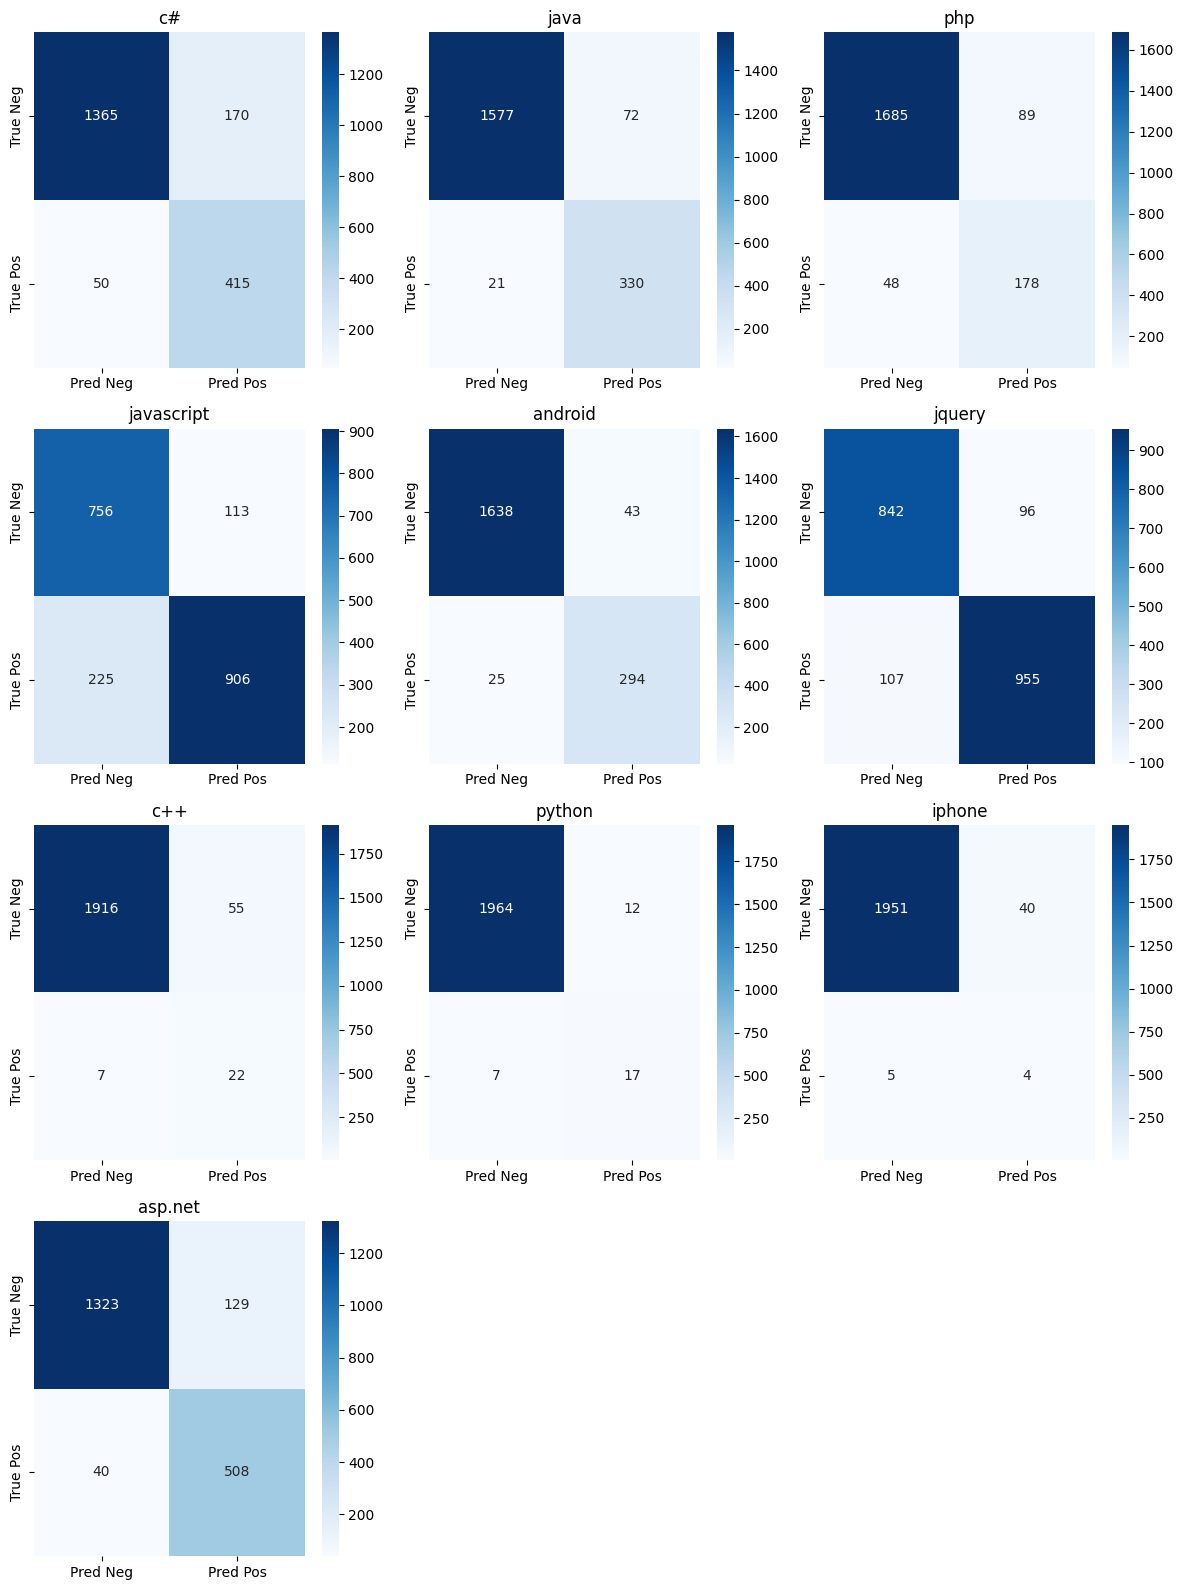

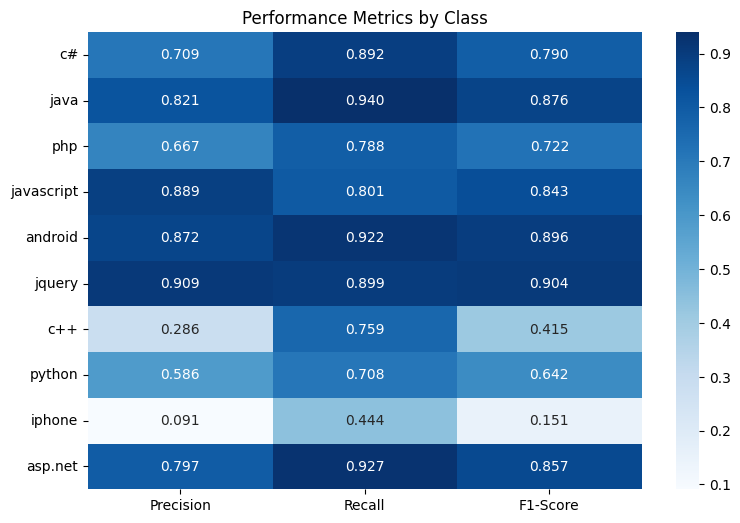

<Figure size 1200x533.333 with 0 Axes>

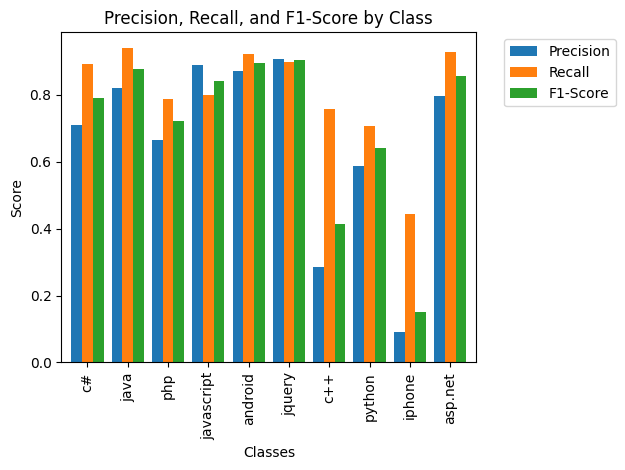

{'macro_avg': {'precision': 0.6627451346689217,
  'recall': 0.8080598250955457,
  'f1': 0.7097071109357695},
 'per_class': {'Precision': {'c#': 0.7094017094017094,
   'java': 0.8208955223880597,
   'php': 0.6666666666666666,
   'javascript': 0.8891069676153092,
   'android': 0.8724035608308606,
   'jquery': 0.9086584205518554,
   'c++': 0.2857142857142857,
   'python': 0.5862068965517241,
   'iphone': 0.09090909090909091,
   'asp.net': 0.7974882260596546},
  'Recall': {'c#': 0.8924731182795699,
   'java': 0.9401709401709402,
   'php': 0.7876106194690266,
   'javascript': 0.8010610079575596,
   'android': 0.9216300940438872,
   'jquery': 0.89924670433145,
   'c++': 0.7586206896551724,
   'python': 0.7083333333333334,
   'iphone': 0.4444444444444444,
   'asp.net': 0.927007299270073},
  'F1-Score': {'c#': 0.7904761904761904,
   'java': 0.8764940239043825,
   'php': 0.7221095334685599,
   'javascript': 0.8427906976744186,
   'android': 0.8963414634146342,
   'jquery': 0.9039280643634643,
 

In [86]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

In [87]:
wandb.finish()

eval/accuracy_all,▁▃▆█▇██
eval/accuracy_label,▁▅▆████
eval/f1_macro,▁▄▅████
eval/f1_micro,▁▅▆████
eval/loss,█▃▃▂▁▁▁
eval/runtime,█▂▂▁▂▂▄
eval/samples_per_second,▁▇▇█▇▇▅
eval/steps_per_second,▁▇▇█▇▇▅
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <Font color = 'indianred'> **8. Model Inference**



In [88]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model.config.use_cache = False
# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 8192,
  "model_type": "

In [90]:
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

In [91]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

<font color = 'indianred'> **Test the pipeline on a single example**

In [92]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds


[[{'label': 'c#', 'score': 0.04958902671933174},
  {'label': 'java', 'score': 0.9980732202529907},
  {'label': 'php', 'score': 0.027169233188033104},
  {'label': 'javascript', 'score': 0.09268777817487717},
  {'label': 'android', 'score': 0.997285008430481},
  {'label': 'jquery', 'score': 0.026759279891848564},
  {'label': 'c++', 'score': 0.028007520362734795},
  {'label': 'python', 'score': 0.009125636890530586},
  {'label': 'iphone', 'score': 0.0055549247190356255},
  {'label': 'asp.net', 'score': 0.03676946833729744}]]

In [93]:
def get_positive_labels(pipeline_output, optimal_thresholds):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [94]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['java', 'android']]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [95]:
preds = custom_pipeline(test_split['text'], truncation=True, batch_size = 32, max_length = 512)

In [96]:
preds[0:3]

[[{'label': 'c#', 'score': 0.051082734018564224},
  {'label': 'java', 'score': 0.9980732202529907},
  {'label': 'php', 'score': 0.02843603305518627},
  {'label': 'javascript', 'score': 0.08882029354572296},
  {'label': 'android', 'score': 0.997368335723877},
  {'label': 'jquery', 'score': 0.028007520362734795},
  {'label': 'c++', 'score': 0.027169233188033104},
  {'label': 'python', 'score': 0.009125636890530586},
  {'label': 'iphone', 'score': 0.0060975621454417706},
  {'label': 'asp.net', 'score': 0.03676946833729744}],
 [{'label': 'c#', 'score': 0.9867772459983826},
  {'label': 'java', 'score': 0.6766198873519897},
  {'label': 'php', 'score': 0.00970847625285387},
  {'label': 'javascript', 'score': 0.016914913430809975},
  {'label': 'android', 'score': 0.13117322325706482},
  {'label': 'jquery', 'score': 0.00806199200451374},
  {'label': 'c++', 'score': 0.6279512047767639},
  {'label': 'python', 'score': 0.0060975621454417706},
  {'label': 'iphone', 'score': 0.016914913430809975},
 

In [97]:
results = get_positive_labels(preds, optimal_thresholds)
results[0:3]

[['java', 'android'], ['c#', 'asp.net'], ['php', 'javascript', 'jquery']]